# Dublin Buses - Clean Data

Prerequisites: `00-download-data.ipynb`

Before running the code in this notebook, you must download and concatenate all the original per-day data files into a single parquet file. Please use the above notebook to do this.

In [1]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from geo.geomath import vec_haversine, num_haversine
from geo.df import DataCleaner
from par.allel import parallel_process
from geo.df import mem_usage, categorize_columns

Read the data in parquet format, as generated by the first step. Note that not all columns are being read in.

In [2]:
columns_to_read = ['Timestamp', 'LineID', 'Direction', 'PatternID', 
                   'JourneyID', 'Congestion', 'Lon', 'Lat', 
                   'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']
df = pd.read_parquet("data/sir010113-310113.parquet", columns=columns_to_read)

Inspect the DataFrame memory consumption as read from storage.

In [3]:
mem_usage(df)

' 4997.05 MB'

As it stands, the `PatternID` column can be converted from string to categorical, saving us some precious memory.

In [4]:
df = categorize_columns(df, ['PatternID'])
mem_usage(df)

' 2586.19 MB'

Wow, that was an almost 50% reduction in memory consumption!

## Data Contents
Let us see what the DataFrame contains before any data cleaning.

In [5]:
df.shape[0]

44455133

In [6]:
journeys = df.JourneyID.unique()
journeys.shape[0]

18614

In [7]:
vehicles = df['VehicleID'].unique()
vehicles.shape[0]

911

In [8]:
stops = df['StopID'].unique()
stops.shape[0]

4728

## Data Quality
Here we will synthesize some of the missing features, such as the traveled distance and the average speed. This is done using a naïve approach. We start by calculating the time differences between consecutive observations. Next, we calculate the distance between these points, and finally we can infer the average speed.

Let's start off by sorting the DataFrame using the `VehicleID` and `Timestamp` as keys.

In [9]:
df = df.sort_values(by=['VehicleID', 'Timestamp'])

Next, we extract a series containing the sequence of vehicle identifiers. This will be useful to mark the rows that border consecutive vehicles.

In [10]:
vehicle_df = df['VehicleID']

We don't want to keep the distance between the last point of one vehicle, recorded at the end of the period, and the first point of the next vehicle, which will be recorded at the start of the next period. These values do not make any sense and will be later set to zero. This series will help us determine when to discard a consecutive calculation.

### DataCleaner
The DataCleaner class implements a number of useful features for deriving new features and cleaning the data errors. Here we create an instance that will be reused throughout the notebook.

In [11]:
cleaner = DataCleaner()

### Duration
Let's start by calculating the consecutive durations in seconds. This is stored in a new column named `dt`.

In [12]:
df = cleaner.calculate_dt(df)

### Distance
Now we can calculate the consecutive distances in meters. This makes use of the [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) through a vectorized implementation.

In [13]:
df = cleaner.calculate_dx(df)

Now we must correct the consecutive durations and distances by setting to zero the ones at the beginning of each vehicle sequence. Please remember that these do not make sense as they are measuring durations and distances between different vehicles. The code to do this is simple enough:

In [14]:
df.loc[vehicle_df.diff() != 0, ['dt', 'dx']] = 0.0

The reasoning behind this code is simple: find the rows whose consecutive difference of the vehicle identifier is not zero (this should include the initial `NaN`) and set both distance and duration to zero. Using this simple trick, we were able to process all vehicles with single vectorized operations and skipped grouping altogether.

### Speed
Now that we have consecutive distances and durations, why not have a go and estimate the speed? The calculation is easy enough, just divide each non-zero distance by its corresponding duration and we get the estimated average speed between two consecutive points, what can go wrong?

Again, we will be using vectorization to avoid lengthy computations. The `calculate_speed` function stores the calculated average speed in km/h in a new column named `v`.

In [15]:
df = cleaner.calculate_speed(df)

The speed unit is kilometers per hour so we can get an intuitive sense of what is happening.

Why not have a look at the average speed distribution?

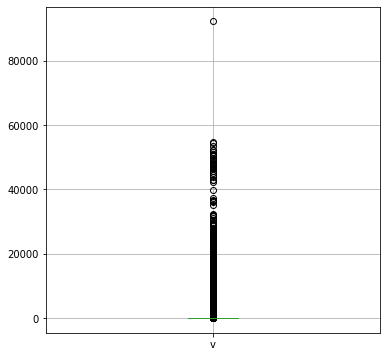

In [16]:
vbx = df['v'].plot.box(grid=True, figsize=(6,6))

Rockets? Probably not. These extreme observations are obviously due to errors in the data. We have to look at the data in detail to see what anomalies we can find. And we don't have to look hard to see some anomalies, like records where the consecutive difference is zero:

In [17]:
df[df.dx == 0].shape[0]

11006525

## Type 1 Anomalies
We will call these _type 1_ anomalies. They are most likely due to GPS reading errors, where the device retains the last-known position, falsely reporting a stop. When the GPS receiver is stationary, it never reports exactly the same latitude and longitude due to a phenomenon called GPS drift. This occurs especially in cities where the opportunities for GPS signal dispersion and reflection are the highest.

Below you can find a sample of the _type 1_ anomalies. The second and third rows are anomalous because they have the exact same location as the first. When we combine the durations for rows 2, 3 and 4 and use that value to calculate the average speed for the three observations, we get a _normal_ average speed.

In [18]:
df.loc[(df.VehicleID == 33488) & 
       (df.Timestamp >= 1357038950000000) & 
       (df.Timestamp <= 1357039012000000), ['Timestamp', 'Lat', 'Lon', 'dt', 'dx', 'v']]

,Timestamp,Lat,Lon,dt,dx,v
111723,1357038950000000,53.271137,-6.326075,20.0,136.837980,24.630836
112020,1357038969000000,53.271137,-6.326075,19.0,0.000000,0.000000
112532,1357039010000000,53.271137,-6.326075,41.0,0.000000,0.000000
112554,1357039012000000,53.272987,-6.318087,2.0,570.253265,1026.455876


In [19]:
"Corrected average speed = {0:.3} km/h".format(570.25 / (19 + 41 + 2) * 3.6)

'Corrected average speed = 33.1 km/h'

Filtering out these errors is easy. Besides removing the rows with zero `dx`, we must make sure that the first vehicle row is not removed.

In [20]:
df = df[(df.dx != 0.0) | (vehicle_df.diff() != 0)].copy()

In [21]:
df.shape

(33449519, 16)

We can now recalculate the average speed and check if our data quality has improved.

In [22]:
df = cleaner.calculate_speed(df)

Unfortunately, the average speed box plot _seems_ untouched. We still get very high average speed observations, meaning that there are still other anomalies that must be tackled.

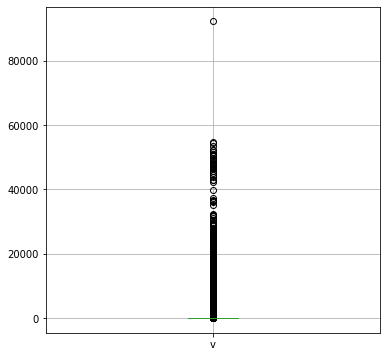

In [23]:
vbx = df.v.plot.box(grid=True, figsize=(6,6))

## Type 2 Anomalies
Digging a bit deeper into the data, we can find some odd anomalies that seem to derive from recorded time errors. Below you can see a typical example of such anomaly. The Blue dots represent the sampled GPS locations of a bus when traveling from north to south (top to bottom). The red dots represent anomalous observations. Although they seem to be inline with the general trajectory, their time sequence is wrong, as can be attested by the green line that connects the dots based on the temporal sequence.

![Type 2 anomalies](./images/anomalous-type-2-points.png "Anomalous type 2 points")

The consequence of these errors is depicted by the large green line segments.

We call these _type 2_ anomalies.

In order to filter the _type 2_ anomalies, we need to determine, on a vehicle basis, what is the expected maximum speed. This is done using a very simple outlier detection technique: Tukey Fences. In this case we want to calculate the top "fence" of the speed distribution.

The `get_top_whisker_speed` function calculates the speed corresponding to the top whisker of a box-and-whiskers plot, using Tukey's fences formulation. The top whisker corresponds to 1.5 times the interquartile range added to the third quartile value. Use this function to calculate the most likely top speed on a per-vehicle basis, when fixing the type 2 anomalies.

In [24]:
def get_top_whisker_speed(df):
    q = df['v'].quantile([.25, .5, .75])
    iqr = q.loc[0.75] - q.loc[0.25]
    return q.loc[0.75] + 1.5 * iqr

The `process_vehicle` function fixes all anomalies on a vehicle partition of the data. After fixing the anomalies, the function returns a dictionary containing the vehicle identifier, the cleaned-up DataFrame, the type 2 anomalies DataFrame, and the _top whisker speed_ value for the vehicle.

In [25]:
def process_vehicle(v, df):
    # df = cleaner.calculate_derived_columns(df)
    # df = cleaner.fix_type1_anomalies(df)
    max_v = get_top_whisker_speed(df)
    df, anomalies = cleaner.fix_type2_anomalies(df, max_speed=max_v)
    return {'v': v, 'df': df, 'anom': anomalies, 'max_v': max_v }

Create an array with the input data for the parallel anomaly correction process. Each array element contains the required parameters for a call to the `process_vehicle` function. Having the data split up by vehicle helps in the parallelization process. Each process looks at a single partition of the data, avoiding data concurrency problems.

In [26]:
vehicle_data = [{'v': v, 'df': df[df['VehicleID'] == v].copy()} for v in tqdm(vehicles)]

We do not need the main DataFrame anymore, so we can do away with it and save some precious memory in the process.

In [27]:
df = None

Now run the parallel process that fixes all the anomalies. Note that this piece of code can take a long time to run, depending on your hardware. The more cores, the better!

In [28]:
fixed_data = parallel_process(vehicle_data, process_vehicle, use_kwargs=True, tqdm=tqdm)

Concatenate the dataset back into a single DataFrame. Note how this is done using a generator compreension. It's a very nice trick!

In [29]:
df = pd.concat((d['df'] for d in tqdm(fixed_data) if isinstance(d, dict)), ignore_index=True)

Do the same for the type 2 anomalies.

In [30]:
anom_df = pd.concat([vd['anom'] for vd in tqdm(fixed_data) if isinstance(vd, dict) and vd['anom'] is not None])

In [31]:
df.shape

(31002957, 16)

In [32]:
anom_df.shape

(1009893, 16)

Save the fixed dataset and the _type 2_ anomaly dataset for possible later analysis.

In [33]:
df.to_parquet("data/fixed.parquet", index=False)

In [34]:
anom_df.to_parquet("data/anomalies.parquet", index=False)

Let's see how the global average speed is now distributed after all the cleaning.

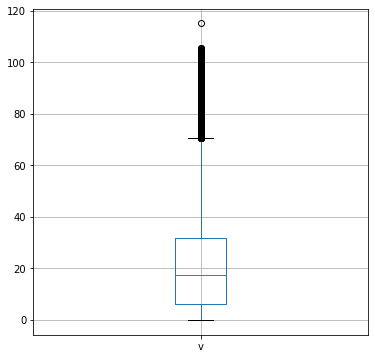

In [37]:
vbx = df.v.plot.box(grid=True, figsize=(6,6))

Calculate the bounding box of the samples and save it on a JSON text file for later use.

In [36]:
import json

bbox = {'west': df['Lon'].min(), 
        'east': df['Lon'].max(), 
        'north': df['Lat'].max(), 
        'south': df['Lat'].min()}

with open('data/bbox.txt', 'w') as json_file:
  json.dump(bbox, json_file)

And we are done for now!